In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the engineered dataset
df = pd.read_csv('engineered_transactions.csv')

# Separate features (X) and target label (y)
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Fraud cases in test set: {y_test.sum()}")

Training set shape: (8240, 13)
Testing set shape: (2060, 13)
Fraud cases in test set: 60


In [2]:
import xgboost as xgb

# Calculate the ratio of negative cases to positive cases for class imbalance
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

# Initialize the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=ratio, # Handles the imbalance
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train the model
print("Training the XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Training complete!")

Training the XGBoost model...
Training complete!


--- Classification Report (Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00        60

    accuracy                           1.00      2060
   macro avg       1.00      1.00      1.00      2060
weighted avg       1.00      1.00      1.00      2060

ROC-AUC Score: 1.0000


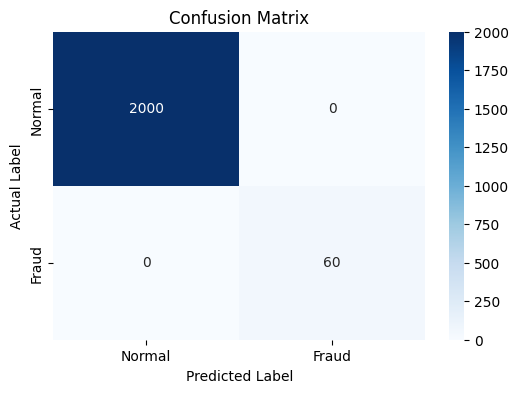

In [3]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Print required metrics
print("--- Classification Report (Precision, Recall, F1-Score) ---")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

C:\Users\panda\AppData\Local\Temp\ipykernel_11400\3316112725.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


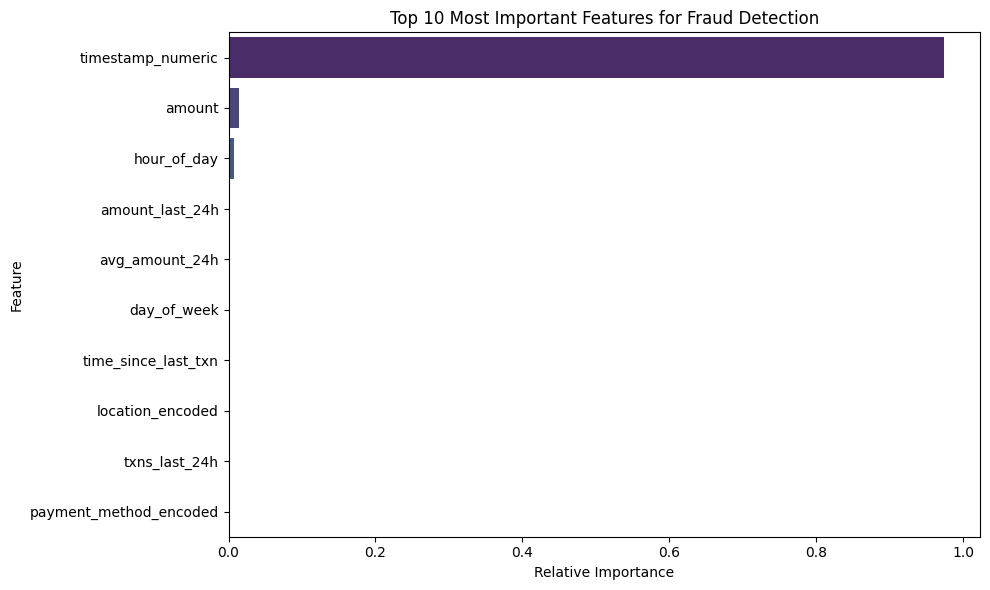

Top 3 Drivers of Fraud:
1. timestamp_numeric
2. amount
3. hour_of_day


In [4]:
# Extract feature importances
importances = xgb_model.feature_importances_
features = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Fraud Detection')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Top 3 Drivers of Fraud:")
for i in range(3):
    print(f"{i+1}. {importance_df.iloc[i]['Feature']}")

In [5]:
# Save the trained XGBoost model to a file
xgb_model.save_model('fraud_model.json')
print("Model saved successfully as fraud_model.json!")

Model saved successfully as fraud_model.json!
